In [50]:
import os
import numpy as np
import cv2
from typing import Optional, Tuple, List
from pathlib import Path
import traceback
import matplotlib.pyplot as plt
import zipfile
import sys
import requests
from scipy.io import loadmat
from imageio import imread
from glob import glob

In [51]:
# Data directory
DATA_DIR = 'data'
# City Centre Dataset
CITY_DATA_DIR = os.path.join(DATA_DIR, 'city')
CITY_IMGZIP_PATH = os.path.join(CITY_DATA_DIR, 'Images.zip')
CITY_IMG_PATH = os.path.join(CITY_DATA_DIR, 'Images')
CITY_GT_PATH = os.path.join(CITY_DATA_DIR, 'CityCentreGroundTruth.mat')
CITY_IMG_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/Images.zip'
CITY_GT_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/CityCentre/masks/CityCentreGroundTruth.mat'
# New College Dataset
COLLEGE_DATA_DIR = os.path.join(DATA_DIR, 'college')
COLLEGE_IMGZIP_PATH = os.path.join(COLLEGE_DATA_DIR, 'Images.zip')
COLLEGE_IMG_PATH = os.path.join(COLLEGE_DATA_DIR, 'Images')
COLLEGE_GT_PATH = os.path.join(COLLEGE_DATA_DIR, 'NewCollegeGroundTruth.mat')
COLLEGE_IMG_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/Images.zip'
COLLEGE_GT_URL = 'http://www.robots.ox.ac.uk/~mobile/IJRR_2008_Dataset/Data/NewCollege/masks/NewCollegeGroundTruth.mat'

def download_file(url, file_name):
    """Downloads a file to destination, skipping download if file exists unless forced.

    Args:
        url: URL of file to download
        file_name: Where to write downloaded file
        force_download: Boolean to force download even if the file exists
    """
    # Ensure destination directory exists
    dest_dir = os.path.dirname(file_name)
    if not os.path.isdir(dest_dir):
        os.makedirs(dest_dir)

    with open(file_name, 'wb') as f:
        print('Downloading {} from {}'.format(file_name, url))
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None:  # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                # Output progress
                complete = dl / total_length
                done = int(50 * complete)
                sys.stdout.write('\r[{}{}] {:6.2f}%'.format('=' * done, ' ' * (50 - done), complete * 100))
                sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()

In [52]:
def get_dataset(name, debug=False):
    debug_amt = 25
    if name.lower() == 'city':  # city centre dataset
        print('Loading the City Centre dataset...')
        # Load images
        print('Loading images')
        if not os.path.isfile(CITY_IMGZIP_PATH):
            download_file(CITY_IMG_URL, CITY_IMGZIP_PATH)
        if not os.path.isdir(CITY_IMG_PATH):
            # Unzip archive
            print('Unzipping {} to {}'.format(CITY_IMGZIP_PATH, CITY_DATA_DIR))
            with zipfile.ZipFile(CITY_IMGZIP_PATH, 'r') as zip_handle:
                zip_handle.extractall(CITY_DATA_DIR)
        # Sort by image number
        img_names = sorted(glob(os.path.join(CITY_IMG_PATH, '*.jpg')))
        assert len(img_names) == 2474
        if debug:
            print('Using fewer images ({}) per debug flag...'.format(
                debug_amt))
            img_names = img_names[:debug_amt]
        imgs = np.asarray([imread(img) for img in img_names])
        # Load GT
        if not os.path.isfile(CITY_GT_PATH):
            download_file(CITY_GT_URL, CITY_GT_PATH)
        print('Loading ground truth')
        gt = loadmat(CITY_GT_PATH)['truth']
        if debug:
            gt = gt[:debug_amt, :debug_amt]
            
    elif name.lower() == 'college':  # new college dataset
        print('Loading the New College dataset...')
        # Load images
        print('Loading images')
        if not os.path.isfile(COLLEGE_IMGZIP_PATH):
            download_file(COLLEGE_IMG_URL, COLLEGE_IMGZIP_PATH)
        if not os.path.isdir(COLLEGE_IMG_PATH):
            # Unzip archive
            print('Unzipping {} to {}'.format(COLLEGE_IMGZIP_PATH,
                                              COLLEGE_DATA_DIR))
            with zipfile.ZipFile(COLLEGE_IMGZIP_PATH, 'r') as zip_handle:
                zip_handle.extractall(COLLEGE_DATA_DIR)
        # Sort by image number
        img_names = sorted(glob(os.path.join(COLLEGE_IMG_PATH, '*.jpg')))
        assert len(img_names) == 2146
        if debug:
            print('Using fewer images ({}) per debug flag...'.format(
                debug_amt))
            img_names = img_names[:debug_amt]
        imgs = np.asarray([imread(img) for img in img_names])
        # Load GT
        if not os.path.isfile(COLLEGE_GT_PATH):
            download_file(COLLEGE_GT_URL, COLLEGE_GT_PATH)
        print('Loading ground truth')
        gt = loadmat(COLLEGE_GT_PATH)['truth']
        if debug:
            gt = gt[:debug_amt, :debug_amt]
    elif name.lower() == 'tsukuba':  # new tsukuba dataset
        raise NotImplementedError
    else:
        raise ValueError('Invalid dataset name: {}.'.format(name))
    return imgs, gt

In [53]:
_, gt = get_dataset("college")

Loading the New College dataset...
Loading images


/var/folders/sn/h8k80m7j0wx704gsf17nmqmm0000gn/T/ipykernel_67570/1933293696.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = np.asarray([imread(img) for img in img_names])


Loading ground truth


In [20]:
class BagOfWordsExtractor:
    def __init__(
        self, 
        vocabulary_size: int = 1000,
        feature_detector: str = 'sift',  # 'sift' or 'orb'
        matching_method: str = 'flann'   # 'flann' or 'bf'
    ):
        """
        Initialize the Bag of Words extractor.
        
        Args:
            vocabulary_size: Number of visual words in vocabulary
            feature_detector: Type of feature detector to use ('sift' or 'orb')
            matching_method: Feature matching method ('flann' or 'bf')
        """
        self.vocabulary_size = vocabulary_size
        self.vocabulary = None
        self.bow_extractor = None
        self.feature_detector = feature_detector
        
        # Initialize feature detector
        if feature_detector.lower() == 'sift':
            self.detector = cv2.SIFT_create()
        elif feature_detector.lower() == 'orb':
            self.detector = cv2.ORB_create()
        else:
            raise ValueError("Feature detector must be 'sift' or 'orb'")
            
        # Initialize feature matcher
        if matching_method.lower() == 'flann':
            if feature_detector.lower() == 'sift':
                # FLANN parameters for SIFT
                FLANN_INDEX_KDTREE = 1
                index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
                search_params = dict(checks=50)
                self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
            else:
                # FLANN parameters for ORB
                FLANN_INDEX_LSH = 6
                index_params = dict(
                    algorithm=FLANN_INDEX_LSH,
                    table_number=6,
                    key_size=12,
                    multi_probe_level=1
                )
                search_params = dict(checks=50)
                self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
        else:
            # Use Brute Force matcher
            if feature_detector.lower() == 'sift':
                self.matcher = cv2.BFMatcher(cv2.NORM_L2)
            else:
                self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING)

    def build_vocabulary(self, training_images: List[np.ndarray]) -> None:
        """
        Build vocabulary from a list of training images.
        
        Args:
            training_images: List of training images as numpy arrays
        """
        print(f"Starting vocabulary building with {len(training_images)} images...")
        
        # Collect all descriptors from training images
        all_descriptors = []
        total_features = 0
        
        for i, img in enumerate(training_images):
            print(f"Processing image {i+1}/{len(training_images)}")
            
            # Convert to grayscale if needed
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img
            
            # Detect and compute features
            keypoints, descriptors = self.detector.detectAndCompute(gray, None)
            
            if descriptors is not None:
                print(f"Image {i+1}: Found {len(keypoints)} keypoints and descriptors shape: {descriptors.shape}")
                total_features += len(descriptors)
                all_descriptors.append(descriptors)
            else:
                print(f"Image {i+1}: No features detected")
        
        if not all_descriptors:
            raise ValueError("No features detected in any of the training images")
        
        print(f"Total features collected: {total_features}")
        
        # Stack all descriptors
        try:
            descriptors_matrix = np.vstack(all_descriptors)
            print(f"Stacked descriptor matrix shape: {descriptors_matrix.shape}")
        except Exception as e:
            print(f"Error stacking descriptors: {e}")
            raise
        
        # Ensure we have float32 type
        descriptors_matrix = np.float32(descriptors_matrix)
        print(f"Descriptor matrix dtype: {descriptors_matrix.dtype}")
        print(f"Descriptor matrix shape: {descriptors_matrix.shape}")
        print(f"Descriptor matrix min/max values: {np.min(descriptors_matrix)}/{np.max(descriptors_matrix)}")
        
        # Adjust vocabulary size if we have fewer features than requested
        if len(descriptors_matrix) < self.vocabulary_size:
            print(f"Warning: Found fewer features ({len(descriptors_matrix)}) than vocabulary size ({self.vocabulary_size})")
            self.vocabulary_size = len(descriptors_matrix)
            print(f"Adjusted vocabulary size to: {self.vocabulary_size}")
        
        # Perform k-means clustering
        print(f"Starting k-means clustering with {self.vocabulary_size} clusters...")
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
        
        try:
            _, labels, vocabulary = cv2.kmeans(
                descriptors_matrix,
                self.vocabulary_size,
                None,
                criteria,
                10,
                cv2.KMEANS_PP_CENTERS
            )
            print("K-means clustering completed successfully")
            self.vocabulary = vocabulary
            
            # Initialize FLANN matcher
            FLAN_INDEX = 6
            index_params= dict(algorithm = FLAN_INDEX,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
            search_params = dict(checks=50)
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
            
            # Initialize BOW extractor
            self.bow_extractor = cv2.BOWImgDescriptorExtractor(self.detector, self.matcher)
            self.bow_extractor.setVocabulary(self.vocabulary)
            print("Vocabulary built successfully!")
            print(f"Final vocabulary shape: {self.vocabulary.shape}")
            
        except Exception as e:
            print(f"Error during k-means clustering: {e}")
            print(f"Descriptor matrix properties:")
            print(f"Shape: {descriptors_matrix.shape}")
            print(f"Type: {descriptors_matrix.dtype}")
            print(f"Contains NaN: {np.isnan(descriptors_matrix).any()}")
            print(f"Contains Inf: {np.isinf(descriptors_matrix).any()}")
            raise

    def extract_bow_features(
        self, 
        image: np.ndarray,
        normalize: bool = True
    ) -> Tuple[np.ndarray, List[cv2.KeyPoint]]:
        """
        Extract Bag of Words features from an image.
        """
        try:
            if self.bow_extractor is None:
                raise ValueError("BOW extractor not initialized. Build or load vocabulary first.")
            
            # Convert to grayscale if needed
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image
            
            keypoints = self.detector.detect(gray, None)
            if not keypoints:
                return np.zeros((1, self.vocabulary_size)), keypoints

            # Extract BoW descriptor
            bow_descriptor = self.bow_extractor.compute(gray, keypoints)
            
            # Normalize if requested
            if bow_descriptor is not None and normalize:
                bow_descriptor = bow_descriptor / (np.sum(bow_descriptor) + 1e-10)
            else:
                return np.zeros((1, self.vocabulary_size)), keypoints
            
            return bow_descriptor, keypoints
        except Exception as e:
            print(traceback.format_exc())
            print("Error extract", e)
            raise e


    def save_vocabulary(self, filepath: str) -> None:
        """Save the vocabulary to a file."""
        if self.vocabulary is None:
            raise ValueError("No vocabulary to save. Build vocabulary first.")
        np.save(filepath, self.vocabulary)

    def load_vocabulary(self, filepath: str) -> None:
        """Load vocabulary from a file."""
        self.vocabulary = np.load(filepath)
        self.bow_extractor = cv2.BOWImgDescriptorExtractor(self.detector, self.matcher)
        self.bow_extractor.setVocabulary(self.vocabulary)

In [21]:
def get_image_bow(
    image_path: str,
    vocabulary_path: Optional[str] = None,
    vocabulary_size: int = 300,
    feature_detector: str = 'orb'
) -> np.ndarray:
    """
    Convenience function to get BoW representation of a single image.
    
    Args:
        image_path: Path to the image
        vocabulary_path: Path to pre-trained vocabulary (optional)
        vocabulary_size: Size of vocabulary if training new one
        feature_detector: Type of feature detector to use
        
    Returns:
        BoW feature vector for the image
    """
    # Initialize extractor
    bow_extractor = BagOfWordsExtractor(
        vocabulary_size=vocabulary_size,
        feature_detector=feature_detector
    )
    
    # Load or train vocabulary
    if vocabulary_path and Path(vocabulary_path).exists():
        bow_extractor.load_vocabulary(vocabulary_path)
    else:
        # Load image for training
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        # Train on single image (not recommended for production)
        bow_extractor.build_vocabulary([img])
        
    # Extract features
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    bow_features, _ = bow_extractor.extract_bow_features(img)
    return bow_features

In [22]:
image_path = "data/college/Images/0002.jpg"
try:
    bow_features = get_image_bow(image_path)
    print(f"BoW features shape: {bow_features.shape}")
except Exception as e:
    print(f"Error processing image: {e}")

Starting vocabulary building with 1 images...
Processing image 1/1
Image 1: Found 500 keypoints and descriptors shape: (500, 32)
Total features collected: 500
Stacked descriptor matrix shape: (500, 32)
Descriptor matrix dtype: float32
Descriptor matrix shape: (500, 32)
Descriptor matrix min/max values: 0.0/255.0
Starting k-means clustering with 300 clusters...
K-means clustering completed successfully
Vocabulary built successfully!
Final vocabulary shape: (300, 32)
Traceback (most recent call last):
  File "/var/folders/sn/h8k80m7j0wx704gsf17nmqmm0000gn/T/ipykernel_67570/381737923.py", line 175, in extract_bow_features
    bow_descriptor = self.bow_extractor.compute(gray, keypoints)
cv2.error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:336: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=5
> 

Error extract OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/flan

In [ ]:
# Example 2: More complex usage with multiple training images
try:
    # Initialize extractor
    bow_extractor = BagOfWordsExtractor(
        vocabulary_size=100,
        feature_detector='sift'
    )
    
    # Load training images (example)
    training_images = []
    training_folder = "data/college/Images/"
    image_files = Path(training_folder).glob("*.jpg")
    for image_file in image_files:
        img = cv2.imread(str(image_file))
        if img is not None:
            training_images.append(img)
    
    # Build vocabulary
    if training_images:
        bow_extractor.build_vocabulary(training_images)
        
        # Optional: save vocabulary for later use
        # using sift because orb was throwing a datatype error on inference
        bow_extractor.save_vocabulary("vocabulary_sift.npy")
        
except Exception as e:
    print(f"Error", e)

Starting vocabulary building with 2146 images...
Processing image 1/2146
Image 1: Found 1616 keypoints and descriptors shape: (1616, 128)
Processing image 2/2146
Image 2: Found 281 keypoints and descriptors shape: (281, 128)
Processing image 3/2146
Image 3: Found 1987 keypoints and descriptors shape: (1987, 128)
Processing image 4/2146
Image 4: Found 3773 keypoints and descriptors shape: (3773, 128)
Processing image 5/2146
Image 5: Found 2002 keypoints and descriptors shape: (2002, 128)
Processing image 6/2146
Image 6: Found 561 keypoints and descriptors shape: (561, 128)
Processing image 7/2146
Image 7: Found 2323 keypoints and descriptors shape: (2323, 128)
Processing image 8/2146
Image 8: Found 3005 keypoints and descriptors shape: (3005, 128)
Processing image 9/2146
Image 9: Found 4874 keypoints and descriptors shape: (4874, 128)
Processing image 10/2146
Image 10: Found 1284 keypoints and descriptors shape: (1284, 128)
Processing image 11/2146
Image 11: Found 2953 keypoints and des

In [6]:
# Process a new image
test_image = cv2.imread("data/college/Images/0003.jpg")
if test_image is not None:
    bow_features, keypoints = bow_extractor.extract_bow_features(test_image)
    print(f"Number of keypoints detected: {len(keypoints)}")
    print(f"BoW feature vector shape: {bow_features.shape}")

error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/flann/src/miniflann.cpp:522: error: (-215:Assertion failed) query.type() == type && indices.type() == CV_32S && dists.type() == dtype in function 'runKnnSearch_'


In [23]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Step 1: Feature Extraction
def extract_features(image_paths):
    orb = cv2.ORB_create()
    descriptors = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img, None)
        if des is not None:
            descriptors.extend(des)
    return descriptors

# Step 2: Codebook Creation
def create_codebook(descriptors, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(descriptors)
    return kmeans

# Step 3: Feature Vectorization
def create_feature_vectors(image_paths, codebook):
    orb = cv2.ORB_create()
    feature_vectors = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        kp, des = orb.detectAndCompute(img, None)
        if des is not None:
            histogram = np.zeros(codebook.n_clusters)
            for descriptor in des:
                cluster_idx = codebook.predict([descriptor])[0]
                histogram[cluster_idx] += 1
            feature_vectors.append(histogram)
    return feature_vectors

In [27]:

# Example usage
training_images = []
training_folder = "data/college/Images/"
image_files = Path(training_folder).glob("*.jpg")
for image_file in image_files:
    training_images.append(str(image_file))
# image_paths = ['data/college/Images/2144.jpg', 'data/college/Images/2145.jpg']  # Replace with your image paths
# labels = [0, 1]  # Replace with corresponding image labels

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2)

# Extract features and create codebook
descriptors = extract_features(training_images)
codebook = create_codebook(descriptors, k=100)  # Adjust k as needed

# Create feature vectors for training and testing sets
X_train_features = create_feature_vectors(training_images, codebook)
# X_test_features = create_feature_vectors(X_test, codebook)

# Train a classifier (e.g., SVM)
# from sklearn.svm import SVC
# clf = SVC()
# clf.fit(X_train_features, y_train)

# # Predict on the test set
# y_pred = clf.predict(X_test_features)

# # Evaluate the classifier
# print(confusion_matrix(y_test, y_pred))

/Users/rateria/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
np.save("vocabulary_orb.npy", X_train_features)

In [30]:
len(X_train_features)

2146

In [35]:
def cosine_similarity_matrix(X: np.ndarray) -> np.ndarray:
    """
    Calculate the cosine similarity between all pairs of vectors in a 2D numpy array.
    
    Args:
        X: A 2D numpy array where each row is a vector.
        
    Returns:
        A 2D numpy array containing the cosine similarity between all pairs of vectors.
    """
    # Step 1: Normalize each vector (row) in the array
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    normalized_X = X / (norms + 1e-10)  # Add small value to avoid division by zero
    
    # Step 2: Compute the cosine similarity using the dot product
    cosine_similarity = np.dot(normalized_X, normalized_X.T)
    
    return cosine_similarity

In [36]:
sim = cosine_similarity_matrix(np.array(X_train_features))

In [37]:
sim.shape

(2146, 2146)

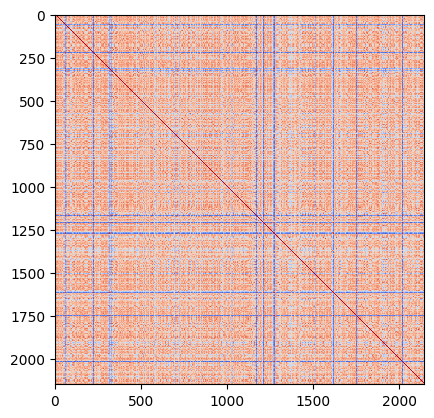

In [39]:
plt.imshow(sim, cmap='coolwarm', interpolation='nearest', vmin=0., vmax=1.)

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score

In [41]:
def mean_per_class_accuracy(y_true, y_pred, n_classes=None, labels=None):
    """ Computes mean per-class accuracy

    Args:
        y_true:    the true labels
        y_pred:    the predicted labels
        n_classes: the number of classes, optional. If not provided, the number of
                   unique classes or length of `labels` if provided.
        labels:    the unique labels, optional. If not provided, unique labels are used
                   if `n_classes` not provided, otherwise range(n_classes).

    Returns:
        mean per-class accuracy
    """
    if n_classes is None:
        if labels is None:
            labels = np.unique(y_true)
        n_classes = len(labels)
    elif labels is None:
        labels = np.arange(n_classes)
    elif len(labels) != n_classes:
        raise ValueError('Number of classes specified ({}) differs from '
                         'number of labels ({}).'.format(n_classes, len(labels)))
    acc = 0.
    for c in labels:
        c_mask = (y_true == c)
        c_count = c_mask.sum()
        if c_count:  # Avoid division by 0
            # Add accuracy for class c
            acc += np.logical_and(c_mask, (y_pred == c)).sum() / c_count
    # Mean accuracy per class
    return acc / n_classes


def compute_and_plot_scores(sim, gt, model_name):
    """ Computes relevant metrics and plots results.

    Args:
        sim:        Similarity matrix
        gt:         Ground truth matrix
        model_name: Name of the model for logging
    """
    # Modify sim matrix to get "real" vector of loop-closures
    # symmetric matrix, take either diagonal matrix, rid diagonal
    sim = sim[np.tril_indices(sim.shape[0], -1)]

    # Ground truth only present in lower diagonal for Oxford datasets
    gt = gt[np.tril_indices(gt.shape[0], -1)]

    # Compute PR-curve
    precision, recall, thresholds = precision_recall_curve(gt, sim)
    average_precision = average_precision_score(gt, sim)
    print('Average Precision: {}'.format(average_precision))

    best_macc = 0.
    best_mthresh = None
    # Compute the best MPC-accuracy at hard-coded thresholds
    thresholds = np.arange(0, 1.02, 0.02)
    for thresh in thresholds:
        sim_thresh = np.zeros_like(sim)
        sim_thresh[sim >= thresh] = 1
        macc = mean_per_class_accuracy(gt, sim_thresh, n_classes=2)
        if macc > best_macc:
            best_macc = macc
            best_mthresh = thresh


    best_f1 = 0.0
    best_f1_thresh = None

    # Calculate F1 score for each threshold
    for thresh in thresholds:
        sim_thresh = np.zeros_like(sim)
        sim_thresh[sim >= thresh] = 1
        f1 = f1_score(gt, sim_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_f1_thresh = thresh

    

    sim_mthresh = np.zeros_like(sim)
    sim_mthresh[sim >= best_mthresh] = 1
    precision_at_mthresh = precision_score(gt, sim_mthresh)
    recall_at_mthresh = recall_score(gt, sim_mthresh)
    print('Best MPC-ACC (thresh={}): {}'.format(best_mthresh, best_macc))
    print('Precision (thresh={}): {}'.format(best_mthresh, precision_at_mthresh))
    print('Recall (thresh={}): {}'.format(best_mthresh, recall_at_mthresh))

    sim_f1thresh = np.zeros_like(sim)
    sim_f1thresh[sim >= best_f1_thresh] = 1
    precision_at_f1thresh = precision_score(gt, sim_f1thresh)
    recall_at_f1thresh = recall_score(gt, sim_f1thresh)
    print("Best F1 Score (thresh={}): {}".format(best_f1_thresh, best_f1))
    print('Precision (thresh={}): {}'.format(best_f1_thresh, precision_at_f1thresh))
    print('Recall (thresh={}): {}'.format(best_f1_thresh, recall_at_f1thresh))

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.3f}'.format(
        average_precision))
    plt.savefig('precision-recall_curve_{}.png'.format(model_name),
                format='png', dpi=150)
    plt.show()

Average Precision: 0.00646329233580431
Best MPC-ACC (thresh=0.4): 0.5051849157572424
Precision (thresh=0.4): 0.006518857723110871
Recall (thresh=0.4): 0.9002831715210357
Best F1 Score (thresh=0.4): 0.012943989352446712
Precision (thresh=0.4): 0.006518857723110871
Recall (thresh=0.4): 0.9002831715210357


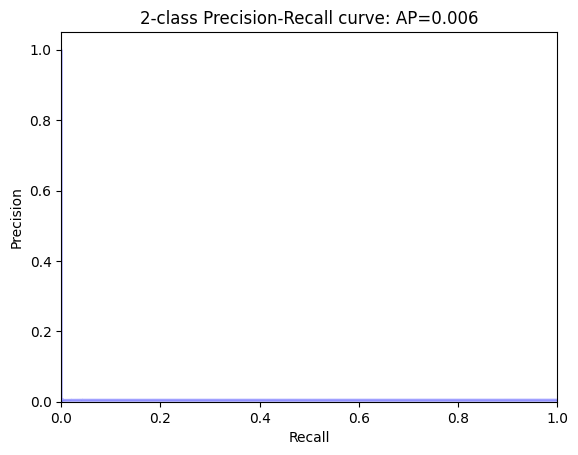

In [54]:
compute_and_plot_scores(sim, gt, "orb")